# FCA sn analysis for MALES - clusters identification and characterization

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures-sn/clustering_males/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.0rc1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
idna                2.10
igraph              0.9.1
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.

'/opt/conda/bin/python'

## Load data

In [2]:
adata = sc.read('FCAsn-M2denoised.h5ad')
adata.X.shape

(7924, 29383)

## Filter females

In [5]:
adata = adata[[ i in 'Hrv15' for i in adata.obs['donor']]]

In [6]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 2822
Total number of genes: 29383


### Identify cells behaving like cc genes
Per genes analysis: identify genes behaving like known cell cycle genes

In [7]:
bdata = adata.copy()
# Normalize total counts per cell
sc.pp.normalize_per_cell(bdata, counts_per_cell_after=1e4)
# Logarithmize the data matrix
sc.pp.log1p(bdata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [8]:
# Extract highly variable genes
sc.pp.highly_variable_genes(bdata)
highly_variable_genes = bdata.var["highly_variable"]
bdata = bdata[:, highly_variable_genes]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [9]:
# Traspose matrix for a GENE-centered analysis
bdata = bdata.copy().T
bdata.X.shape

(6549, 2822)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:01)


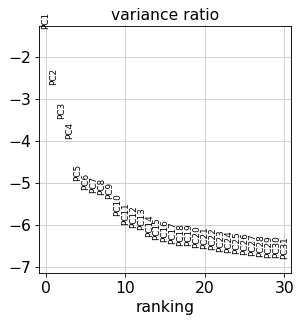

In [10]:
# Scale data to unit variance and zero mean
sc.pp.scale(bdata, max_value=10)

# Scatter plot in PCA coordinates
sc.tl.pca(bdata)
bdata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
# Plot the variance ratio
sc.pl.pca_variance_ratio(bdata, log=True, save='_ccg_identification.pdf')

In [11]:
num_pcs = 10
# Compute a neighborhood graph of observations
sc.pp.neighbors(bdata, n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(bdata)
# Cluster GENES into subgroups using leiden: resolution < 1 to find less clusters
sc.tl.leiden(bdata, resolution=1)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [13]:
# Locate ccs cluster
bdata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in bdata.obs_names]
# sc.pl.umap(bdata, color=['known_cyclers', 'leiden'], color_map='OrRd',save='_ccg_identification.pdf')
print(bdata.obs.loc[[i in ['CDK1','MKI67','CCNB2','PCNA'] for i in bdata.obs_names],'leiden'])

CCNB2    13
CDK1     13
MKI67    13
PCNA     13
Name: leiden, dtype: category
Categories (19, object): ['0', '1', '2', '3', ..., '15', '16', '17', '18']


In [14]:
ccgs_cl = bdata.obs.loc['CCNB2',['leiden']][0]
print("Cell cycle genes cluster is "+ccgs_cl)

Cell cycle genes cluster is 13


### Remove ccgs

In [15]:
# Add unstructured dict-like annotation for ccgs
adata.uns['ccgs'] = list(bdata.obs[bdata.obs['leiden']==ccgs_cl].index)

Trying to set attribute `.uns` of view, copying.


In [16]:
# Remove cc genes
print('Total number of genes before ccg filter: {:d}'.format(adata.n_vars))
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes before ccg filter: 29383
Total number of genes after ccg filter: 29117


### Normalize per cell and log transform

After removing unwanted cells and genes from the dataset, the next step is to normalize the data. 
By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. 

In [17]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Filter HVGs in bdata and do PCA with them

In [18]:
bdata = adata.copy()
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
for col in ['highly_variable','means', 'dispersions', 'dispersions_norm']:
    adata.var[col] = bdata.var[col]
bdata = bdata[:, bdata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Total number of cells: 2822
Total number of genes: 6384


In [19]:
sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


## Transfer PCA to the main adata

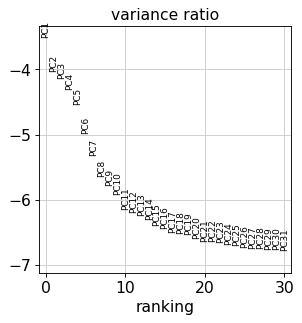

In [20]:
#fill NaNs with False so that subsetting to HVGs is possible
adata.var['highly_variable'].fillna(value=False, inplace=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
adata.uns['pca'] = bdata.uns['pca'].copy()
adata.varm['PCs'] = np.zeros(shape=(adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable']] = bdata.varm['PCs']
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

### UMAP

In [21]:
n_pcs = 14

In [22]:
# Visualize
sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 14
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


## Clustering the graph
As Seurat and many others, we use the leiden graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by Levine et al. (2015).

In [23]:
sc.tl.leiden(adata, resolution=0.3)
# sc.tl.leiden(adata, resolution=0.2)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


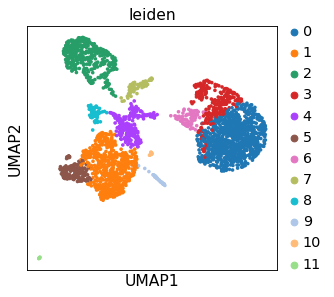

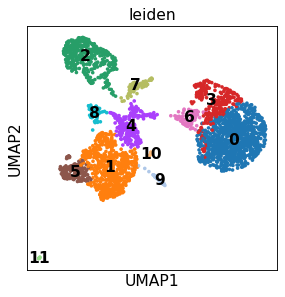

In [24]:
sc.pl.umap(adata, color='leiden' )
sc.pl.umap(adata, color=['leiden'],legend_loc='on data',save='_clustering_clusnumbers.pdf' )

### Visualize general markers

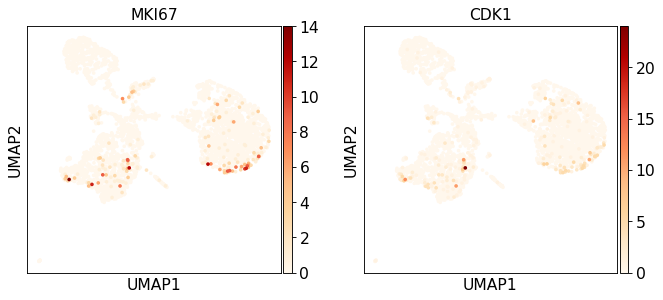

In [25]:
sc.pl.umap(adata, color=['MKI67', 'CDK1'], save='-markers_cycling.pdf',color_map='OrRd', use_raw=True)

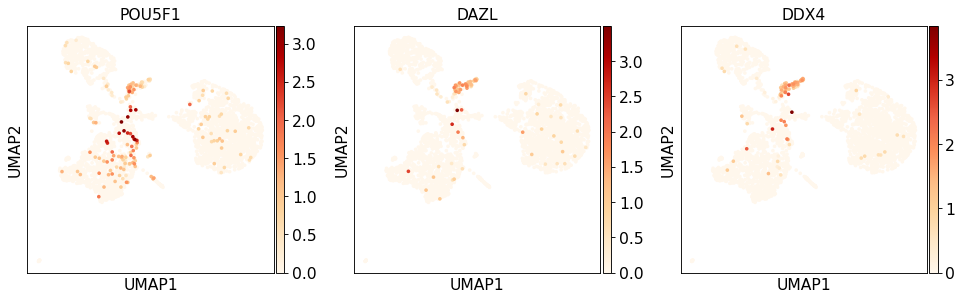

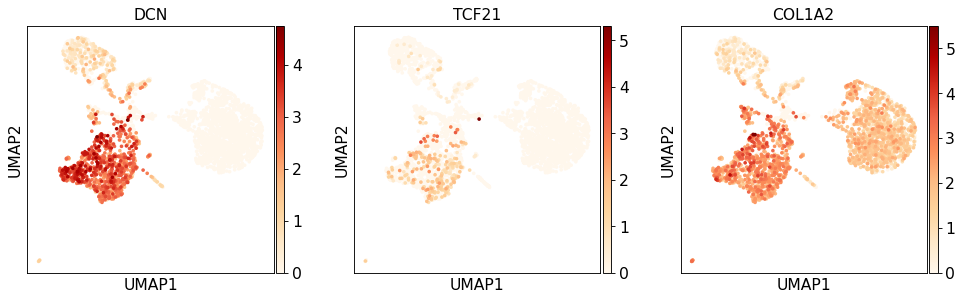

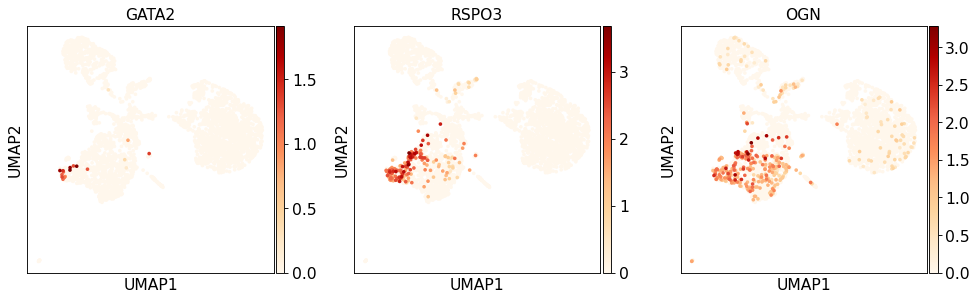

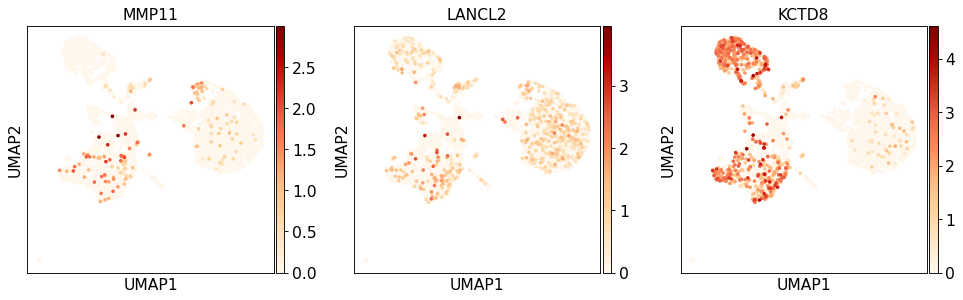

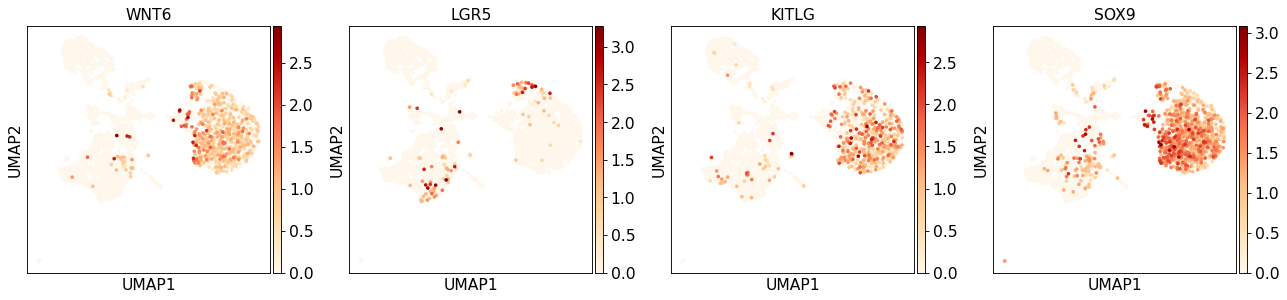

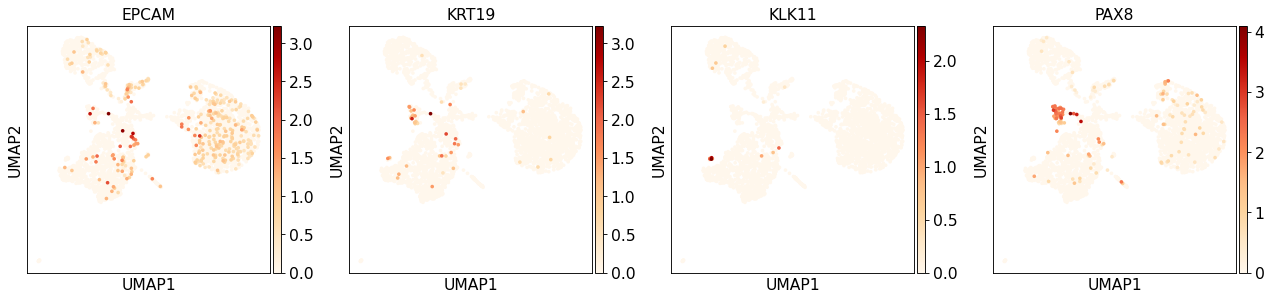

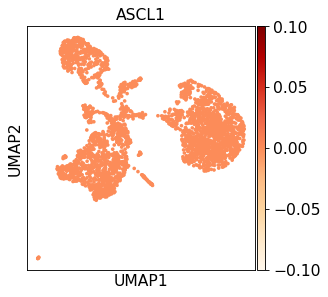

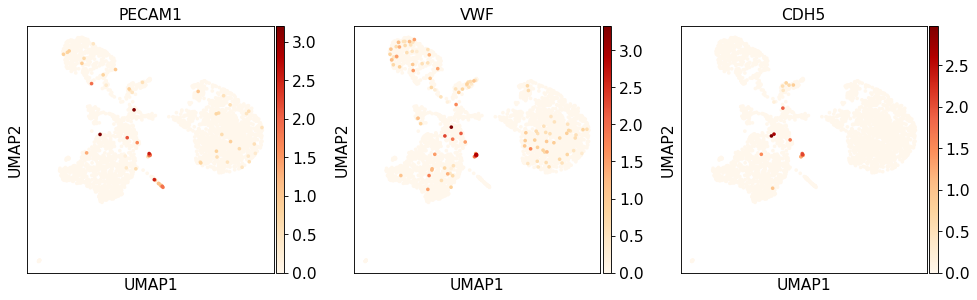

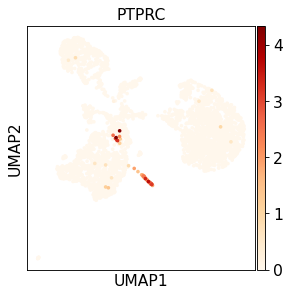

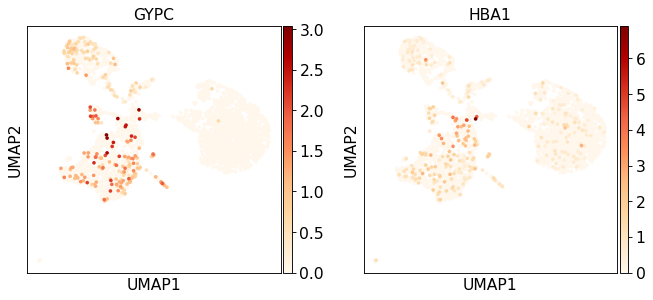

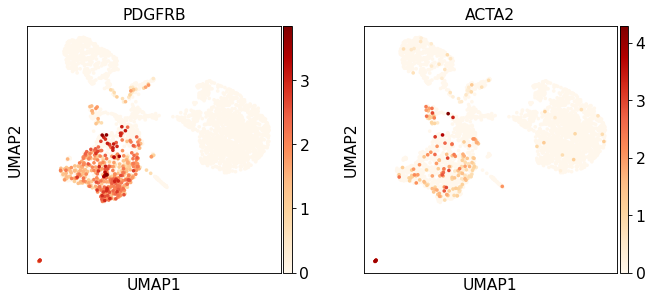

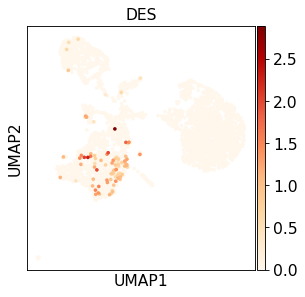

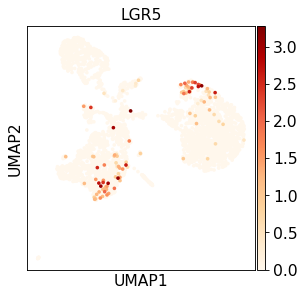

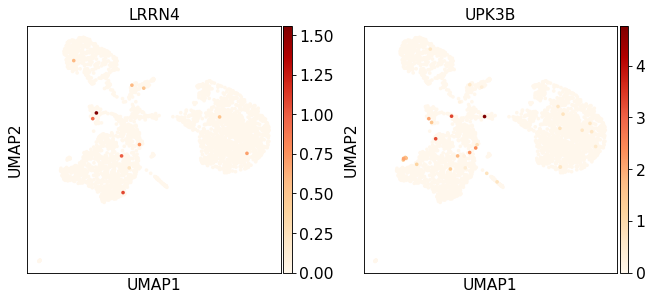

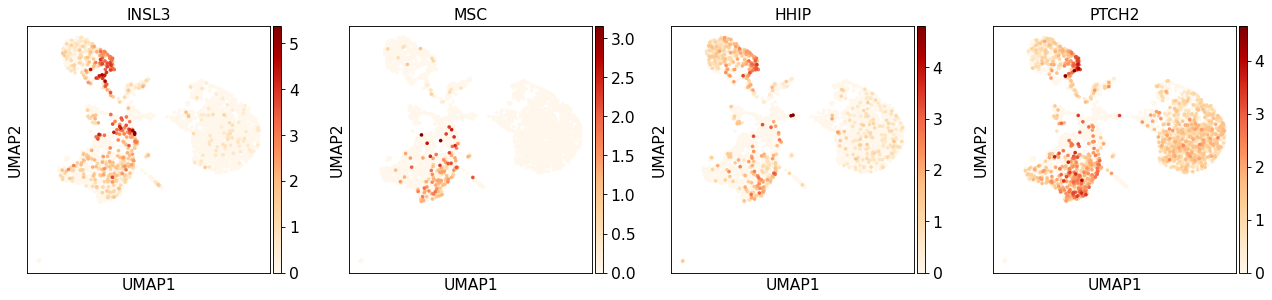

In [26]:
sc.pl.umap(adata, color=["POU5F1", 'DAZL', "DDX4"], save='-markers_germcell.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['DCN', 'TCF21', 'COL1A2'], save='-markers_stromal.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['GATA2', 'RSPO3', 'OGN'], save='-markers_stromalExtragonad.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['MMP11', 'LANCL2', 'KCTD8'], save='-markers_stromalGonad.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=["WNT6", 'LGR5', "KITLG", 'SOX9'], save='-markers_supporting.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=["EPCAM", "KRT19", 'KLK11', 'PAX8'], save='-markers_epithelial.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['ASCL1'], save='-markers_neural.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['PECAM1', 'VWF', 'CDH5'], save='-markers_endothelial.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['PTPRC'], save='-markers_immuneCD45.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=["GYPC", "HBA1"], save='-markers_erythroid.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=["PDGFRB", 'ACTA2'], save='-markers_perivascula.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['DES'], save='-markers_smoothmusclecell.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['LGR5'], save='-markers_somaProgenitors.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['LRRN4', 'UPK3B'], save='-markers_mesothelial.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['INSL3', 'MSC', 'HHIP', 'PTCH2'], save='-markers_Leydig.pdf',color_map='OrRd', use_raw=False )

Check the germ cells

In [27]:
PGCS_cl = ['7']

PGCs_our = [i for i in adata.obs['leiden'].values if i in PGCS_cl ]
print('Number of PGCs in our analysis: ', len(PGCs_our))
pgcs_obs = adata.obs[ np.asarray([i in PGCS_cl for i in adata.obs['leiden'].values])]

Number of PGCs in our analysis:  70


### Check global trends

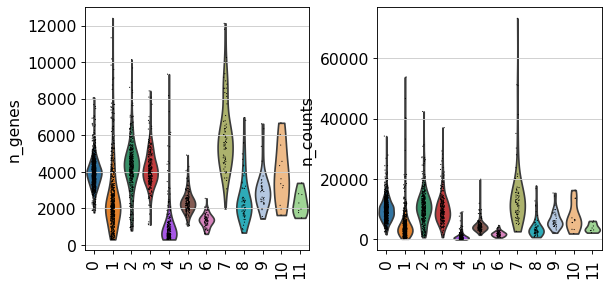

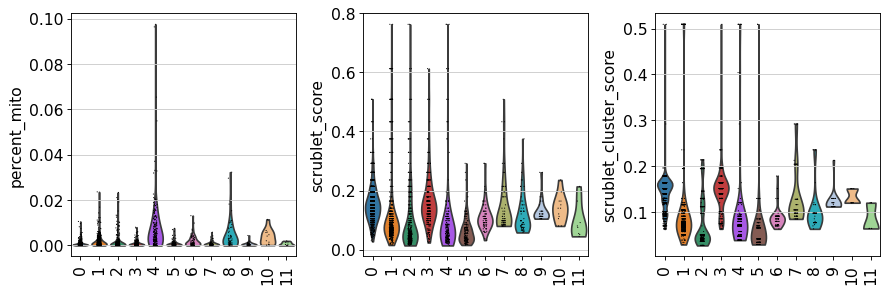

In [28]:
sc.pl.violin(adata, keys= ['n_genes', 'n_counts'], groupby = 'leiden', save='_clusters_statsI.pdf', rotation = 90)
sc.pl.violin(adata, keys= ['percent_mito', 'scrublet_score', 'scrublet_cluster_score'], groupby = 'leiden', save='_clusters_statsII.pdf', rotation = 90)

## Save adata

In [29]:
adata.write('FCAsn-M3denoised_clusters_male.h5ad')

# Finding marker genes

Compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes with a t test, which agrees quite well with Seurat.

## All vs rest

### TF-IDF based

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


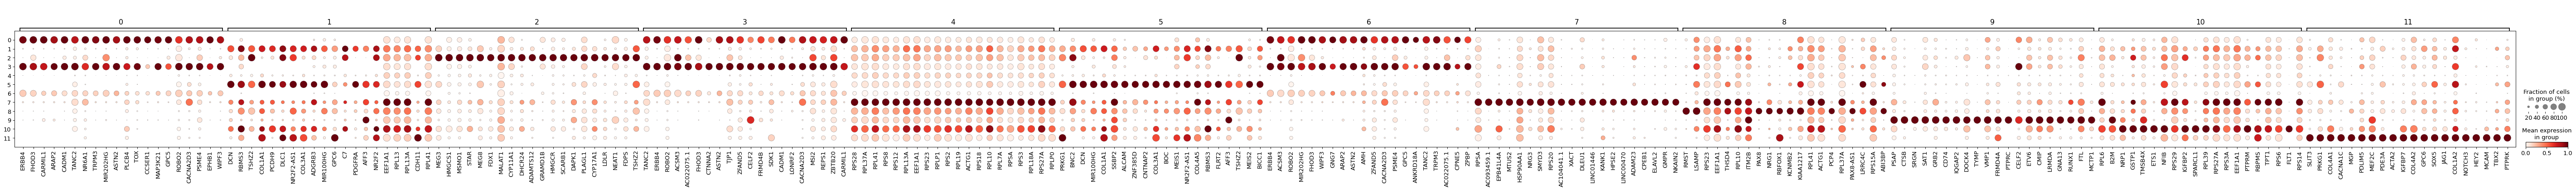

In [30]:
#Compute Mann-Withney test with scanpy
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False) #, method='logreg'
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata, n_genes=20, dendrogram=False, save='_scanpy.pdf', standard_scale = 'var')

In [31]:
adata_counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)

In [32]:
# Binarize counts matrix (1 if expressed, 0 otherwise)
import episcanpy as epi
adata_bin = epi.pp.binarize(adata_counts, copy=True)
adata_bin.X.shape
# Compute TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(adata_bin.X.T)
adata_bin.X = tfidf.T
adata_bin.X.shape

(2822, 29383)

In [33]:
#Compute Mann-Withney test with scanpy
sc.tl.rank_genes_groups(adata_bin, groupby='leiden', use_raw=False) #, method='logreg'

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


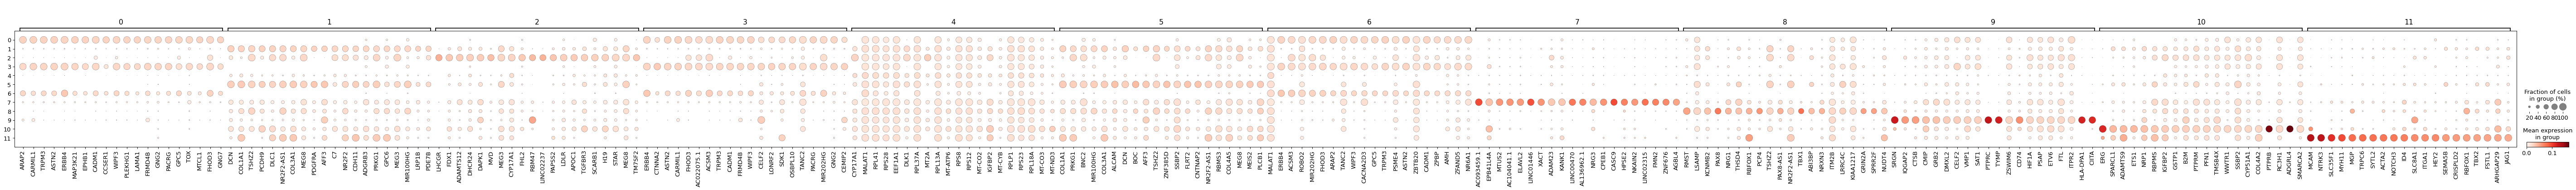

In [34]:
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=20, dendrogram=False, save='_rawtfidf_scanpy.pdf')

In [35]:
# Plot with gene expression normalized values
sc.pp.normalize_per_cell(adata_counts, counts_per_cell_after=1e4)
sc.pp.log1p(adata_counts)
sc.pp.scale(adata_counts, max_value=10)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


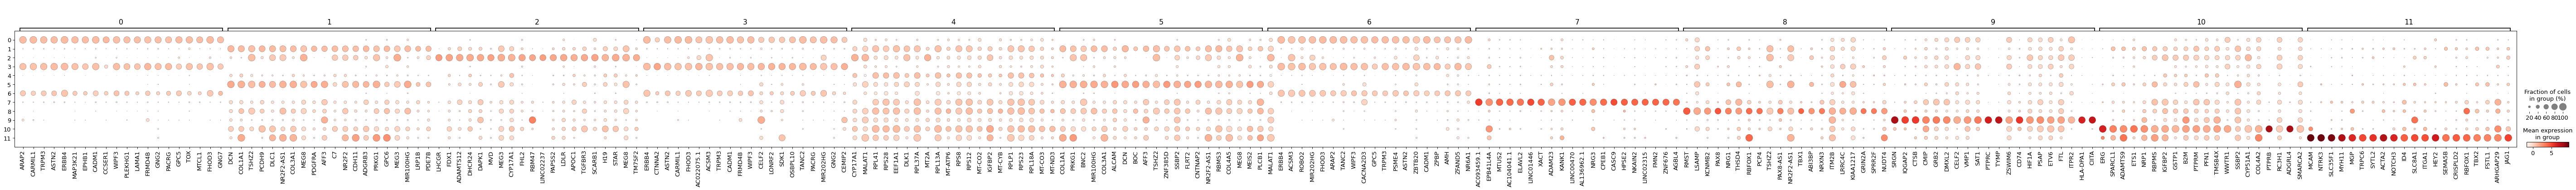

In [36]:
adata_counts.uns['rank_genes_groups'] = adata_bin.uns['rank_genes_groups']
sc.pl.rank_genes_groups_dotplot(adata_counts, n_genes=20, dendrogram=False, save='_tfidf_scanpy.pdf', use_raw = False)

In [37]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

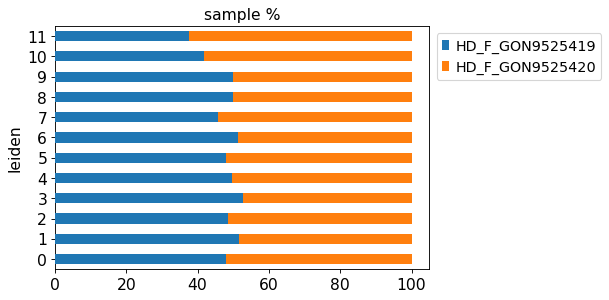

In [38]:
Barplot('sample', adata, var='leiden', height=4)

In [50]:
marker_genes = {
    'sLGR5': {'LGR5', 'TSPAN8', 'CXCR4'},
    'Sertoli': {'SOX9', 'INHBB', 'DHH', 'CLDN11'},
    'mesothelial': {'LRRN4', 'UPK3B', 'KLK11'},
#     'Female supporting':{"KITLG", 'FOXL2', 'RSPO1'},
    'Supporting':{"WNT6", 'WIPF3', 'GATA4'},
    'Stromal':{'COL1A2', 'DCN', 'PDGFRA'},
    'Stromal_Meso':{'RSPO3', 'GATA2'},
    'Stromal_Gonad':{'MMP11', 'LANCL2', 'KCTD8'},
    'Leydig':{'INSL3', 'GLI1', 'HHIP', 'PTCH2', 'FDX1'},
    'PGCs': {'POU5F1', 'NANOG', 'NANOS3', 'KIT'},
    'Germ Cells': {'DAZL', 'SPO11', 'DDX4'},
    'epithelial': {"EPCAM", "KRT19", 'PAX8'},
    'neural': {'ASCL1'},
    'endothelial': {'PECAM1', 'VWF', 'CDH5'},
    'immune': {'PTPRC'},
    'erythroid': {"GYPC", "HBA1"},
    'perivascular': {"PDGFRB", 'ACTA2'},
    'erythroid': {"GYPC", "HBA1"},
    'cycling': {'CDK1', 'MKI67', 'TOP2A'}
}

In [51]:
marker_matches = sc.tl.marker_gene_overlap(adata_bin, marker_genes, method = 'overlap_coef')
marker_matches = marker_matches.set_axis('cl_'+marker_matches.columns, axis=1, inplace=False)

<AxesSubplot:>

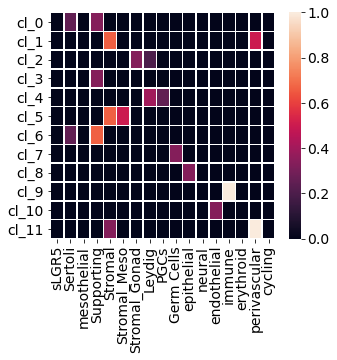

In [52]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,4))  
sns.heatmap(marker_matches.T, annot=False, xticklabels=True, yticklabels=True, linewidths=0.5, ax= ax)

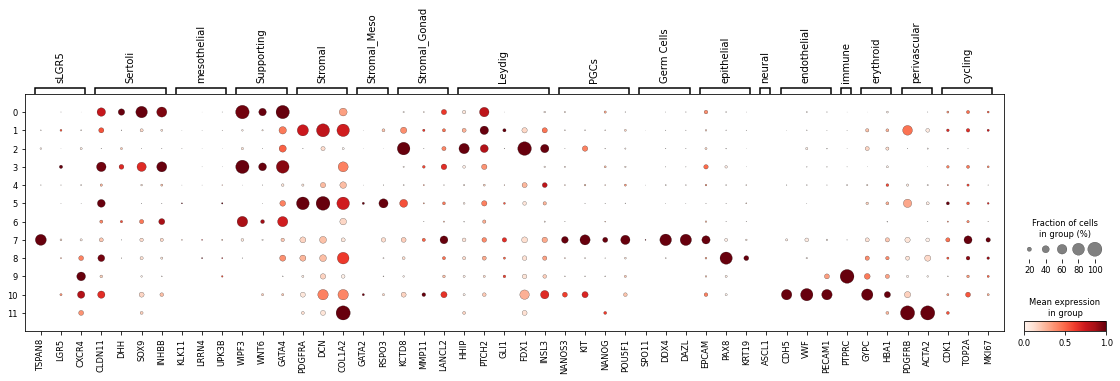

In [53]:
sc.pl.dotplot(adata_counts, marker_genes, groupby='leiden', standard_scale='var')

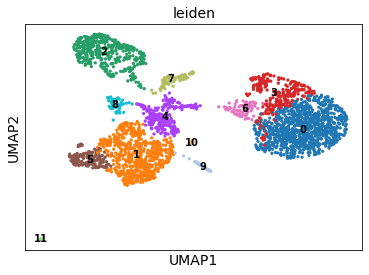

In [48]:
sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

... storing 'clusters' as categorical


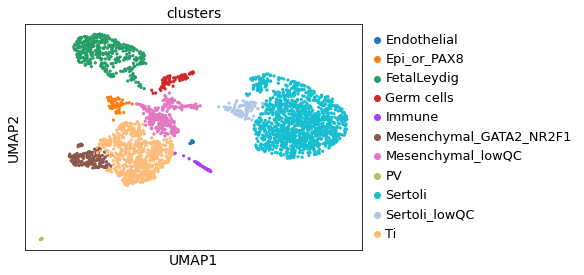

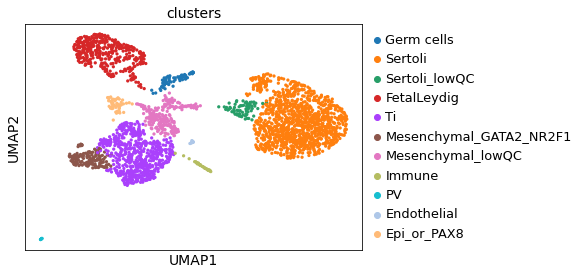

In [56]:
adata.obs['clusters'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['clusters'] == '0', 'clusters'] = 'Sertoli'
adata.obs.at[adata.obs['clusters'] == '1', 'clusters'] = 'Ti'
adata.obs.at[adata.obs['clusters'] == '2', 'clusters'] = 'FetalLeydig'
adata.obs.at[adata.obs['clusters'] == '3', 'clusters'] = 'Sertoli'
adata.obs.at[adata.obs['clusters'] == '4', 'clusters'] = 'Mesenchymal_lowQC'
adata.obs.at[adata.obs['clusters'] == '5', 'clusters'] = 'Mesenchymal_GATA2_NR2F1'
adata.obs.at[adata.obs['clusters'] == '6', 'clusters'] = 'Sertoli_lowQC'
adata.obs.at[adata.obs['clusters'] == '7', 'clusters'] = 'Germ cells'
adata.obs.at[adata.obs['clusters'] == '8', 'clusters'] = 'Epi_or_PAX8'
adata.obs.at[adata.obs['clusters'] == '9', 'clusters'] = 'Immune'
adata.obs.at[adata.obs['clusters'] == '10', 'clusters'] = 'Endothelial'
adata.obs.at[adata.obs['clusters'] == '11', 'clusters'] = 'PV'
set(adata.obs['clusters'])
sc.pl.umap(adata, color=['clusters'])
adata.obs['clusters'].cat.reorder_categories(['Germ cells', 'Sertoli','Sertoli_lowQC',  'FetalLeydig',
                                              'Ti', 'Mesenchymal_GATA2_NR2F1' , 'Mesenchymal_lowQC',
                                              'Immune', 
                                              'PV', 'Endothelial', 'Epi_or_PAX8'], inplace=True)

sc.pl.umap(adata, color=['clusters'])

In [57]:
pd.DataFrame(adata.obs).to_csv('/nfs/team292/lg18/with_valentina/dual_snRNAsnATAC_male_Hrv15.csv')